In [3]:
import json
from pymongo import MongoClient
import pandas as pd
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6, inferno
import numpy as np
from bokeh.models import ColumnDataSource
from bokeh.io import show, output_notebook
from scipy.spatial import distance
import matplotlib.pyplot as plt
from bokeh.models import HoverTool

In [4]:
# Make connection to MongoDB Server
MONGODB_URL=''
client = MongoClient(MONGODB_URL)

In [5]:
# Get list of collections under datamanager folder
database_name = 'datamanager'
database = client[database_name]
collection = database.list_collection_names(include_system_collections=False)
for collect in collection:
    print(collect)

airport_wait_time
clientAiports
flightStatuses
flightTracks
airports
_schema
equipments
requests
airlines
runs


In [6]:
# Get list of all headings under the currently chosen collection (flightTracks)
db = client.datamanager
curs=db.flightTracks.find()
for c in curs[0]:
    print(c)

_id
flightId
bearing
heading
flightNumber
delayMinutes
departureAirportFsCode
departureDate
arrivalAirportFsCode
request_id
carrierFsCode
equipment
tailNumber
callsign
positions


In [7]:
# # Peak at the data in the currently chosen collection (flightTracks) by looking at first entry
# db = client.datamanager
# curs=db.flightTracks.find()
# for c in curs[0:1]:
#     print(c)

In [8]:
# Look at how many distinct entries exist for each of the headings in currently chosen collection (flightTracks)

# info=db.flightTracks.distinct('_id') # 3761 found, ObjectID's inside
# info=db.flightTracks.distinct('flightId') # 3761 found, integers inside
# info=db.flightTracks.distinct('bearing') # 3727 found, floats inside
# info=db.flightTracks.distinct('heading') # 3748 found, floats inside
# info=db.flightTracks.distinct('delayMinutes') # 167 found, integers inside
# info=db.flightTracks.distinct('departureAirportFsCode') # 244 found, airport name strings inside
# info=db.flightTracks.distinct('departureDate') # 2204 found, date dicts inside
# info=db.flightTracks.distinct('arrivalAirportFsCode') # 192 found, airport name strings inside
# info=db.flightTracks.distinct('request_id') # 68 found, ObjectID's inside
# info=db.flightTracks.distinct('carrierFsCode') # 142 found, carrier code strings inside
info=db.flightTracks.distinct('equipment') # 70 found, equipment code strings inside
# info=db.flightTracks.distinct('tailNumber') # 2268 found, tail number strings inside
# info=db.flightTracks.distinct('callsign') # 1205 found, call sign strings inside

# info=db.flightTracks.distinct('positions') # Too large to check as each contains all data along the way

print(len(info))
print(info)

95
['359', '789', '388', '77W', '32B', '744', '788', '333', '772', '321', '75W', '74H', '320', '75C', '332', '7S8', '77X', '74Y', '74N', '77L', '319', '76Y', 'M1F', '76V', '32A', '73W', 'E75', '76W', '73H', '75T', '74E', '73J', '76C', '32Q', '343', '32N', '738', '76E', '31B', '773', '735', 'CR2', 'CR7', '733', 'A81', 'CCX', '32S', 'D1X', '781', '737', 'E90', '717', '736', 'CN7', 'ABY', 'CNJ', '73G', 'CJL', '346', '763', 'D1Y', 'PL2', 'EP3', 'AB3', 'BE9', '33X', 'CN2', '75D', '739', 'CJ8', 'C28', 'CL5', 'LRJ', '330', '76X', 'GJ4', 'E95', 'CRJ', 'EM2', '752', '73S', '747', '290', 'H24', 'CL3', 'T20', 'EM4', 'D20', 'BET', 'EP1', '74F', 'CCJ', 'GJ6', 'GR2', 'DF3']


In [9]:
# Create list of all equipment
equip_list = db.flightTracks.distinct('equipment')

In [10]:
# Definition returns minimum euclidean distance between provided node and target node
def closest_node(comp_node, nodes):
    # Note nodes is a list of tuples
    node_list = []
    if len(nodes[0])>2:
        for index,node in enumerate(nodes):
            node_list.append((node[0],node[1]))
    else:
        node_list = nodes
    closest_index = distance.cdist([comp_node], node_list).argmin()
#     print(nodes[closest_index])
    return nodes[closest_index]

In [11]:
# Filter currently chosen collection (flightTracks) by chosen entry from above and display in dataframe
# In this box consider only those flights departing from LAX

def read_in_flights(filter_code,lat_lon_range):
    # No filtering is filter_code=0
    # Filter by departing from LAX is filter_code=1
    # Filter by arriving to LAX is filter_code=2

    lax_coord = [33.9416, -118.4085]
    # Range of latitudes and longitudes around LAX to include
    lat_min = lax_coord[0] - lat_lon_range
    lat_max = lax_coord[0] + lat_lon_range
    lon_min = lax_coord[1] - lat_lon_range
    lon_max = lax_coord[1] + lat_lon_range

    df = pd.DataFrame()
    
    num_flagged = 0
    # Go through each type of equipment one at a time
    for i,elem in enumerate(equip_list):
        print('Going through equipment-type %i of %i' %(i,len(equip_list)))

        # Right now only consider planes departing form LAX
        if filter_code == 0:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem})),
                              columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                       'departureDate','positions'])
            start_index = 0
            end_index = -1
        elif filter_code == 1:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem ,
                                                     'departureAirportFsCode':'LAX'})),
                         columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                  'departureDate','positions'])
            start_index = -60
            end_index = -1
        elif filter_code == 2:
            data=pd.DataFrame(list(db.flightTracks.find({'equipment':elem ,
                                                         'arrivalAirportFsCode':'LAX'})),
                             columns=['_id','departureAirportFsCode','arrivalAirportFsCode','equipment',
                                      'departureDate','positions'])
            start_index = 0
            end_index = 60
            
        num_flagged += data.shape[0]
            
        # No go through each flight within this type of equipment
        out = []
        out_dates = []
        first_date_rec = []
        first_date_pos = []
        last_date_rec = []
        last_date_pos = []
        skip_list = [True] * data.shape[0]
        # Go through each flight
        for index in range(data.shape[0]):
            temp_df = pd.DataFrame(data.positions[index],
                                   columns=['lat','lon','altitudeFt','date']).iloc[start_index:end_index]
            
            # Store as list of tuples
            temp_df['points'] = list(zip(temp_df.lat,
                                         temp_df.lon,
                                         temp_df.altitudeFt,
                                         temp_df.date))
            
            if len(temp_df)==0:
                skip_list[index] = False
            else:
                # Only include if flight contains points near LAX
                near_node=closest_node(lax_coord, list(zip(temp_df.lat,temp_df.lon)))
                if (near_node[0]<lat_min or near_node[0]>lat_max):
                    skip_list[index] = False
                if (near_node[1]<lon_min or near_node[1]>lon_max):
                    skip_list[index] = False

#             first_date_rec.append(temp_df.date.min())
#             last_date_rec.append(temp_df.date.max())
#             first_date_pos.append((temp_df.lat.loc[temp_df.date==temp_df.date.min()].values[0],
#                                   temp_df.lon.loc[temp_df.date==temp_df.date.min()].values[0]))
#             last_date_pos.append((temp_df.lat.loc[temp_df.date==temp_df.date.max()].values[0],
#                                   temp_df.lon.loc[temp_df.date==temp_df.date.max()].values[0]))
            
            # Append list of tuples for particular plane
            out.append(temp_df.points.values)
            out_dates.append(data.departureDate[index]['dateUtc'])
            
        # Skip if empty
        if len(data)==0:
            continue
            
#         print(data.shape)
#         print(len(out))
        # Add these tuples to the original dataframe and remove the positions column
        data['points'] = out
        data['date'] = out_dates
        ######## Uncomment below if investigating this #########
#         data['First_Date_Rec'] = first_date_rec
#         data['Last_Date_Rec'] = last_date_rec
#         data['First_Pos_Rec'] = first_date_pos
#         data['Last_Pos_Rec'] = last_date_pos
        
        # Before returning filter out those rows flagged as being skipped
        data = data[skip_list]
        
        data.drop(columns=['positions'],inplace=True)
        # Before moving to next type of equipment merge this with the master dataframe
        df = pd.concat([df, data], axis=0, sort=False)
    
    
    ###### Split departure date into multiple features (Uncomment if investigating this) ########
#     if not df.empty: # Below only makes sense if at least one flight found 
#         df['dep_date'] = pd.to_datetime(df['date'])
#         df['dep_year'] = df['dep_date'].dt.year 
#         df['dep_month'] = df['dep_date'].dt.month 
#         df['dep_day'] = df['dep_date'].dt.day 
#         df['dep_hour'] = df['dep_date'].dt.hour 
#         df['dep_minute'] = df['dep_date'].dt.minute 

    df.reset_index(inplace=True)
    return df, num_flagged


In [12]:
filter_code = 1 # For departing from LAX
lat_lon_range = 0.5 # Range around LAX to include for filtering
dep_LAX_df, num_flagged = read_in_flights(filter_code,lat_lon_range)

print('In total %i flights found for investigated' % num_flagged)
print('In total %i flights were found for chosen filtering' %dep_LAX_df.shape[0])
dep_LAX_df.head(1)

Going through equipment-type 0 of 95
Going through equipment-type 1 of 95
Going through equipment-type 2 of 95
Going through equipment-type 3 of 95
Going through equipment-type 4 of 95
Going through equipment-type 5 of 95
Going through equipment-type 6 of 95
Going through equipment-type 7 of 95
Going through equipment-type 8 of 95
Going through equipment-type 9 of 95
Going through equipment-type 10 of 95
Going through equipment-type 11 of 95
Going through equipment-type 12 of 95
Going through equipment-type 13 of 95
Going through equipment-type 14 of 95
Going through equipment-type 15 of 95
Going through equipment-type 16 of 95
Going through equipment-type 17 of 95
Going through equipment-type 18 of 95
Going through equipment-type 19 of 95
Going through equipment-type 20 of 95
Going through equipment-type 21 of 95
Going through equipment-type 22 of 95
Going through equipment-type 23 of 95
Going through equipment-type 24 of 95
Going through equipment-type 25 of 95
Going through equipmen

index                       _id departureAirportFsCode  \
0      0  5d0f6fa90473a81fe3146ec5                    LAX   

  arrivalAirportFsCode equipment  \
0                  TNA       359   

                                       departureDate  \
0  {'dateLocal': '2019-06-23T00:55:00.000', 'date...   

                                              points                      date  
0  [(37.4656, -121.6896, 36000.0, 2019-06-23T08:5...  2019-06-23T07:55:00.000Z

In [70]:
filter_code = 2 # For arriving to LAX
lat_lon_range = 0.5 # Range around LAX to include for filtering
arr_LAX_df,num_flagged = read_in_flights(filter_code,lat_lon_range)

print('In total %i flights found for investigated' % num_flagged)
print('In total %i flights were found for chosen filtering' %arr_LAX_df.shape[0])
arr_LAX_df.head(1)

In total 6218 flights found for investigated
In total 3470 flights were found for chosen filtering


index                       _id departureAirportFsCode  \
0     71  5d1e147af29131e74d8d51fa                    SIN   

  arrivalAirportFsCode equipment  \
0                  LAX       359   

                                       departureDate  \
0  {'dateLocal': '2019-07-04T20:55:00.000', 'date...   

                                              points  \
0  [(33.9922, -118.236, 2572.0, 2019-07-05T04:24:...   

                       date            First_Date_Rec  \
0  2019-07-04T12:55:00.000Z  2019-07-05T03:39:07.000Z   

              Last_Date_Rec         First_Pos_Rec         Last_Pos_Rec  \
0  2019-07-05T04:24:10.000Z  (36.6805, -123.6036)  (33.9922, -118.236)   

                   dep_date  dep_year  dep_month  dep_day  dep_hour  \
0 2019-07-04 12:55:00+00:00      2019          7        4        12   

   dep_minute  
0          55

In [12]:
# filter_code = 0 # For arriving to LAX
# lat_lon_range = 0.5 # Range around LAX to include for filtering
# full_df,num_flagged = read_in_flights(filter_code,lat_lon_range)

# print('In total %i flights found for investigated' % num_flagged)
# print('In total %i flights were found for chosen filtering' %full_df.shape[0])
# full_df.head(1)

In [57]:
# # Read in the standard and arrival procedures from the file

# f = open("/Users/bryan/Box Sync/_Airport-Planning-Solutions/28DaySubscription_Effective_2019-06-20/STARDP.txt", "r")
# prev_code = 'S0000'
# code_list = []
# name_list = []
# proc_vers_list = []

# lax_coord = [33.9416, -118.4085]
# lat_lon_range = .1
# # Range of latitudes and longitudes around LAX to include
# lat_min = lax_coord[0] - lat_lon_range
# lat_max = lax_coord[0] + lat_lon_range
# lon_min = lax_coord[1] - lat_lon_range
# lon_max = lax_coord[1] + lat_lon_range

# pos_tuple_list = []
# for line in f:
    
#     line = line.split()
    
#     # Skip if empty
#     if len(line)==0:
#         continue
        
#     code = line[0]
#     code_list.append(code)
    
#     # Check if we are going on to a new procedure
#     if not (code==prev_code): # Meaning we hit a new procedure
#         # If line longer then usual grab new name for procedure (if provided)
#         if len(line)>4:
#             name = ' '.join([line[-2],line[-1]])
#             vers_num = 1
#         proc_vers = 'V' + str(vers_num)
#     elif len(line)>4: # Hits this if we hit new procedure under same code
#         vers_num += 1
#         proc_vers = 'V' + str(vers_num)
        
    
#     # Save current name
#     name_list.append(name)
#     proc_vers_list.append(proc_vers)
    
#     # Update as previous code
#     prev_code = code
        
#     coord_piece = line[2]
#     lat_piece = coord_piece[0:8]
#     if lat_piece[0]=='N':
#         lat_piece = float(lat_piece[1:8])/(10**5)
#     else:
#         lat_piece = -float(lat_piece[1:8])/(10**5)

#     lon_piece = coord_piece[8:17]
#     if lon_piece[0]=='E':
#         lon_piece = float(lon_piece[1:8])/(10**4)
#     else:
#         lon_piece = -float(lon_piece[1:8])/(10**4)
    
#     pos_name = coord_piece[17:]
#     pos_tuple_list.append((lat_piece,lon_piece,pos_name))

# # Turn into Pandas DataFrame
# STARS_df = pd.DataFrame({'Code':code_list, 'Name':name_list, 'Proc_Variation':proc_vers_list,
#                          'Positions':pos_tuple_list})
# # Groupby Code and Name and turn Positions into list of tuples
# STARS_df=pd.DataFrame(STARS_df.groupby(['Code','Name','Proc_Variation'])['Positions'].apply(list))
# STARS_df.reset_index(level=['Code', 'Name', 'Proc_Variation'],inplace=True)

# # Now filter out all procedures which do not correspond to LAX
# skip_list = [True] * STARS_df.shape[0]
# for index in range(STARS_df.shape[0]):
#     temp_series = STARS_df.loc[index]
#     pos_list = temp_series[3]
    
#     # Only include if flight contains points near LAX
#     near_node=closest_node(lax_coord, pos_list)
#     if (near_node[0]<lat_min or near_node[0]>lat_max):
#         skip_list[index] = False
#     if (near_node[1]<lon_min or near_node[1]>lon_max):
#         skip_list[index] = False
# # Before returning filter out those rows flagged as being skipped
# STARS_df = STARS_df[skip_list]
# STARS_df.reset_index(inplace=True,drop = True)

# # print(STARS_df.shape)
# STARS_df.head(10)

In [34]:
# print(list(STARS_df.Name))
# print(STARS_df.loc[STARS_df.Name=='BIGBR THREE'])

In [56]:
# # Range of planes to plot
# plot_min=0
# # plot_max=347
# plot_max = STARS_df.shape[0]

# p = figure(title="STARS Trajectories")
# color_mapper = linear_cmap('index', inferno(256), plot_min, plot_max)

# for i in range(plot_min,plot_max):

#     # Overlay all flights on each other
#     temp_df = STARS_df.iloc[i-1:i]
# #     print(temp_df.Code.values[0])
    
#     # Gather list of latitude and longitude points for each flight separately
#     for elem in temp_df.Positions:
#         lat = [item[0] for item in elem]
#         lon = [item[1] for item in elem]
#         pos_name = [item[2] for item in elem]
#         proc_order = list(range(len(elem)))
        
#         index_list = np.ones(len(lat))*i
#         proc_name_list = [temp_df.Name.values[0]]*len(lat)
#         source = ColumnDataSource(
#             data=dict(lat=lat,
#                       lon=lon,
#                       pos_name=pos_name,
#                       proc_order=proc_order,
#                       proc_name_list=proc_name_list,
#                       index=index_list)
#         )
        
#         p.line(lon, lat, line_width=2)
#         p.circle(x="lon", y="lat", size=9, fill_alpha=0.1, source=source, color=color_mapper, name="foo")

# # Implement interactivity
# my_hover = HoverTool(names=["foo"])
# my_hover.tooltips = [('Longitude','@lon'),('Latitude', '@lat'),('Proc Step Num','@proc_order'),
#                      ('Position Name','@pos_name'),('Procedure Name','@proc_name_list')]
# p.add_tools(my_hover)
    
# output_notebook()  
# show(p)

In [98]:
# print(np.unique(dep_LAX_df.dep_day))
# plt.plot()
# dep_LAX_df.dep_hour.hist(figsize=(10,10),bins=24)
# plt.title('Departing Hour For Flights From LAX')
# plt.xlabel('Time (UTC)')

In [99]:
# full_df['date'] = pd.to_datetime(full_df['date'])
# full_df['year'] = full_df['date'].dt.year 
# full_df['month'] = full_df['date'].dt.month 
# full_df['day'] = full_df['date'].dt.day 
# full_df['hour'] = full_df['date'].dt.hour 
# full_df['minute'] = full_df['date'].dt.minute 

# print(np.unique(full_df.year))
# print(np.unique(full_df.month))
# print(np.unique(full_df.day))
# print(np.unique(full_df.hour))
# # full_df.head()

In [36]:
# Make copy of dataframe to plot and select equipment type to examine
df_plot = dep_LAX_df.copy(deep=True)

# Range of planes to plot
plot_min=0
plot_max=200

p = figure(title="Flight Trajectories Departing From LAX")

# color_mapper = linear_cmap('index', 'Viridis256', 0, df_plot.shape[0])
color_mapper = linear_cmap('index', inferno(256), plot_min, plot_max)

print('There are %i different trajectories chosen for plotting' %(plot_max-plot_min))

for i in range(plot_min,plot_max):

    # Overlay all flights on each other
    temp_df = df_plot.iloc[i-1:i]
    
    # Gather list of latitude and longitude points for each flight separately
    for elem in temp_df.points:
        lat = [item[0] for item in elem]
        lon = [item[1] for item in elem]
        
        index_list = np.ones(len(lat))*i
        source = ColumnDataSource(
            data=dict(lat=lat,
                      lon=lon,
                      index=index_list)
        )

        p.circle(x="lon", y="lat", size=2, fill_alpha=0.1, source=source, color=color_mapper)

output_notebook()  
show(p)

There are 200 different trajectories chosen for plotting


Loading BokehJS ...

Loading BokehJS ...

Text(0.5, 0, 'Time (UTC)')

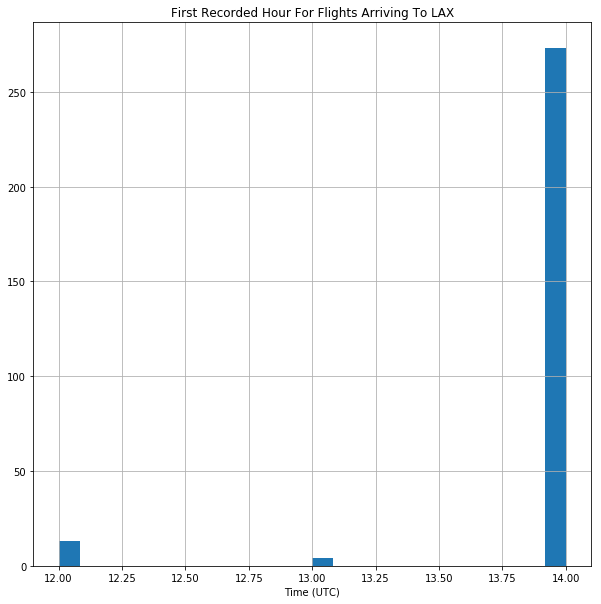

In [14]:
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper

to_inves_df = arr_LAX_df.copy(deep=True)
to_inves = pd.DataFrame({'First_Date_Rec':to_inves_df.First_Date_Rec,'First_Pos_Rec':to_inves_df.First_Pos_Rec,
                         'Last_Date_Rec':to_inves_df.Last_Date_Rec,'Last_Pos_Rec':to_inves_df.Last_Pos_Rec})

# Make into datetime objects
to_inves['First_Date_Rec'] = pd.to_datetime(to_inves['First_Date_Rec'])
to_inves['Last_Date_Rec'] = pd.to_datetime(to_inves['Last_Date_Rec'])

# Add hour features
to_inves['First_Date_Hour'] = to_inves['First_Date_Rec'].dt.hour 
to_inves['Last_Date_Hour'] = to_inves['Last_Date_Rec'].dt.hour 

p = figure(title="Flights Flagged as Departing From LAX")
color_mapper = linear_cmap('time', inferno(4), 12, 15)
# color_mapper = LinearColorMapper(palette="Viridis256", low=13, high=15)
# from bokeh.models import LinearColorMapper
# color_mapper = LinearColorMapper(palette='Viridis256', low = 12, high = 16)


# Go through each flight
lat_list = []
lon_list = []
time_list = []
for i in range(to_inves.shape[0]):
    temp_df = to_inves.iloc[i-1:i]
    # Skip if no data
    if temp_df.shape[0]==0:
        continue
    
    lat_list.append(temp_df.First_Pos_Rec.values[0][0])
    lon_list.append(temp_df.First_Pos_Rec.values[0][1])
    time_list.append(temp_df.First_Date_Hour.values[0])

source = ColumnDataSource(
    data=dict(lat=lat_list,
              lon=lon_list,
              time=time_list)
)


p.circle(x="lon", y="lat", size=4, fill_alpha=0.9, source=source, color=color_mapper)

# from bokeh.models import ColorBar
# bar = ColorBar(color_mapper=color_mapper, location=(0,0))
# p.add_layout(bar, "left")

# plot.add_layout(color_bar, 'right')
    
output_notebook()  
show(p)

plt.plot()
to_inves.Last_Date_Hour.hist(figsize=(10,10),bins=24)
plt.title('First Recorded Hour For Flights Arriving To LAX')
plt.xlabel('Time (UTC)')

In [13]:
# Here we will attempt clustering using avg dist. between trajectories

# Taken from here: https://github.com/Shathra/comparing-trajectory-clustering-methods/blob/master/demo/demo.ipynb

import urllib
import zipfile
import os
import scipy.io
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN



# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    
    plt.show()

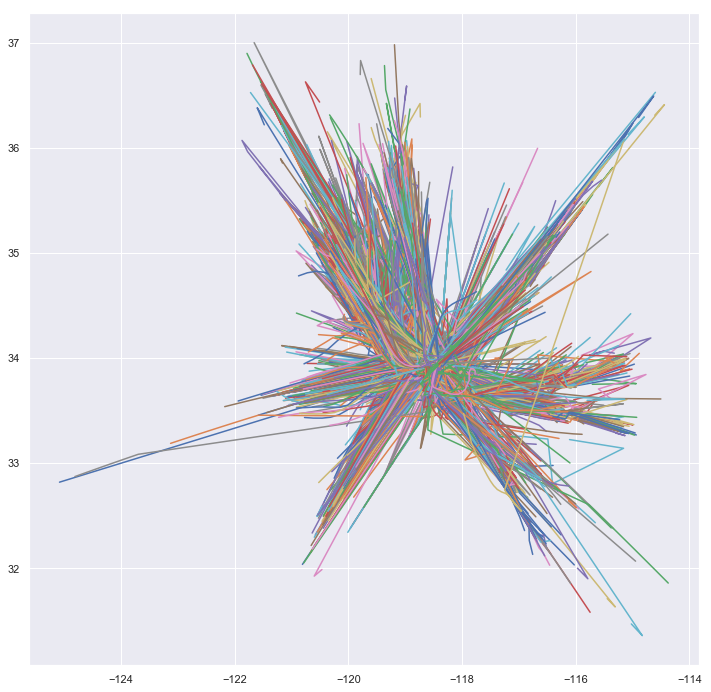

In [14]:

    
traj_data = dep_LAX_df.points
# Cutoffs for considering flights valid
min_lon = -126
max_lon = -114
min_lat = 28
max_lat = 37

num_points_keep = 30

traj_lst = []
for flight_instance in traj_data:
    flight_instance = flight_instance[-num_points_keep:] # Use for departing flights
#     flight_instance = flight_instance[:num_points_keep] # Use for arriving flights
    temp_pos_list = []
    # Start with values which are immediately replaced
    curr_min_lat = 1000
    curr_max_lat = -1000
    curr_min_lon = 1000
    curr_max_lon = -1000
    for point in flight_instance:
        if point[0]<curr_min_lat:
            curr_min_lat = point[0]
        if point[0]>curr_max_lat:
            curr_max_lat = point[0]
        if point[1]<curr_min_lon:
            curr_min_lon = point[1]
        if point[1]>curr_max_lon:
            curr_max_lon = point[1]
        # Append to list
        temp_pos_list.append([point[0],point[1]])
    # Now check if previous flight was within bounds or not before keeping
    if (curr_min_lat<min_lat or curr_max_lat>max_lat or curr_min_lon<min_lon or curr_max_lon>max_lon):
        continue
    traj_lst.append(np.vstack(temp_pos_list))

# Plot initial trajectories
for traj in traj_lst:
    plt.plot(traj[:, 1], traj[:, 0])

# 2 - Trajectory segmentation

degree_threshold = 5

for traj_index, traj in enumerate(traj_lst):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst[traj_index] = traj[hold_index_lst, :]
    


In [15]:
# 3 - Distance matrix

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst)
# traj_count = 500 # Temporary for check
D = np.zeros((traj_count, traj_count))


# This may take a while
for i in range(traj_count):
    if i%50 == 0:
        print('Looking at trajectory %i out of %i' %(i,traj_count))
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst[i], traj_lst[j])
        D[i, j] = distance
        D[j, i] = distance

Looking at trajectory 0 out of 6955
Looking at trajectory 50 out of 6955
Looking at trajectory 100 out of 6955
Looking at trajectory 150 out of 6955
Looking at trajectory 200 out of 6955
Looking at trajectory 250 out of 6955
Looking at trajectory 300 out of 6955
Looking at trajectory 350 out of 6955
Looking at trajectory 400 out of 6955
Looking at trajectory 450 out of 6955
Looking at trajectory 500 out of 6955
Looking at trajectory 550 out of 6955
Looking at trajectory 600 out of 6955
Looking at trajectory 650 out of 6955
Looking at trajectory 700 out of 6955
Looking at trajectory 750 out of 6955
Looking at trajectory 800 out of 6955
Looking at trajectory 850 out of 6955
Looking at trajectory 900 out of 6955
Looking at trajectory 950 out of 6955
Looking at trajectory 1000 out of 6955
Looking at trajectory 1050 out of 6955
Looking at trajectory 1100 out of 6955
Looking at trajectory 1150 out of 6955
Looking at trajectory 1200 out of 6955
Looking at trajectory 1250 out of 6955
Looking a

There were 2 clusters found


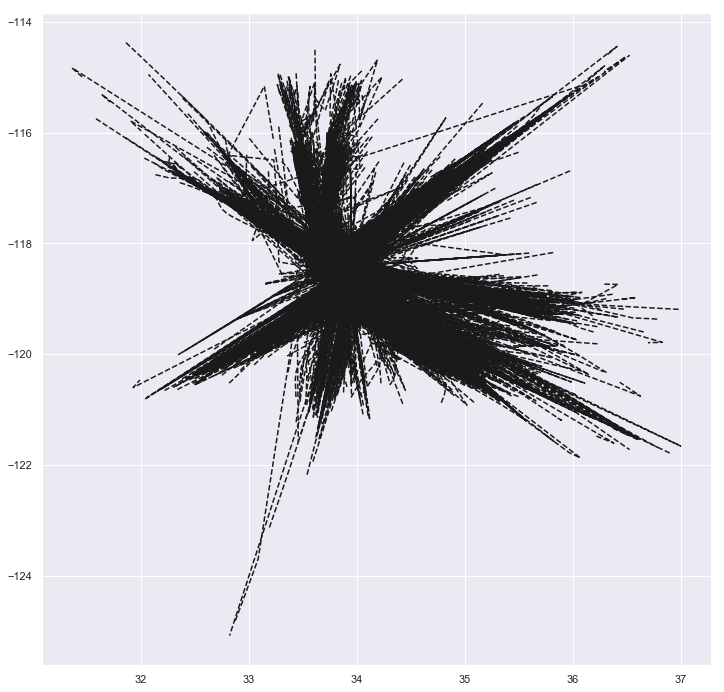

In [20]:
mdl = DBSCAN(eps=1, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 20 clusters found


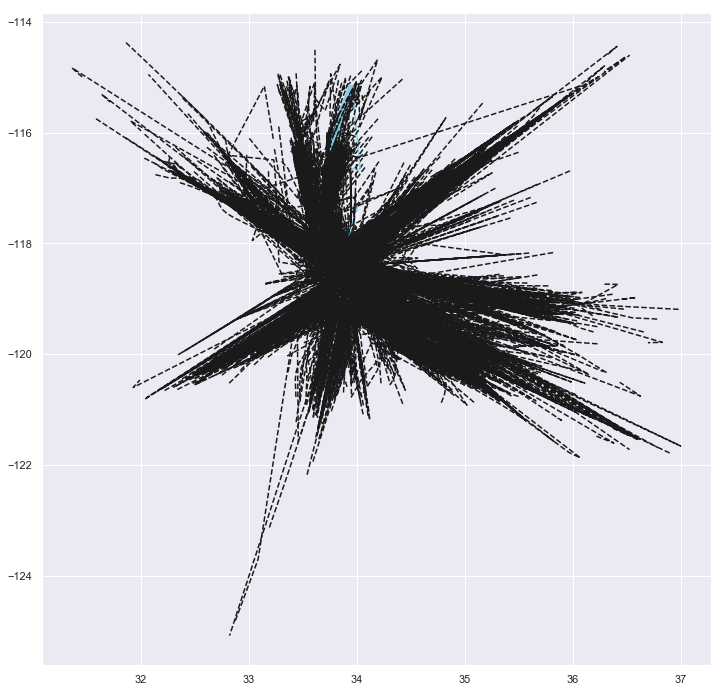

In [22]:
mdl = DBSCAN(eps=1.5, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 93 clusters found


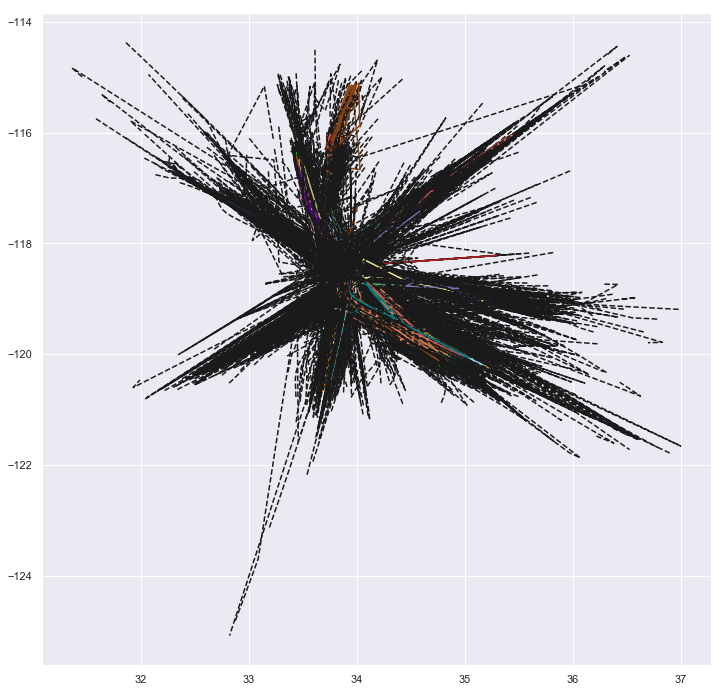

In [18]:
mdl = DBSCAN(eps=2, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 88 clusters found


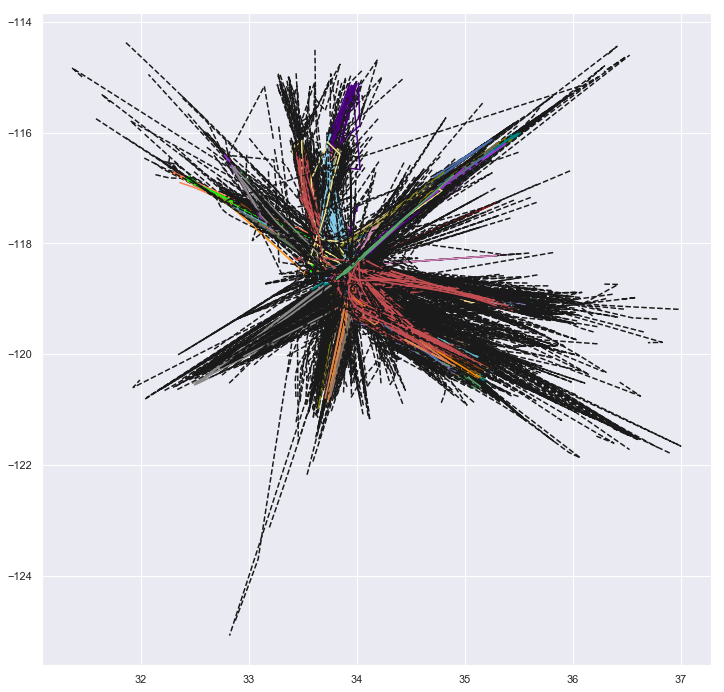

In [31]:
mdl = DBSCAN(eps=2.5, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 60 clusters found


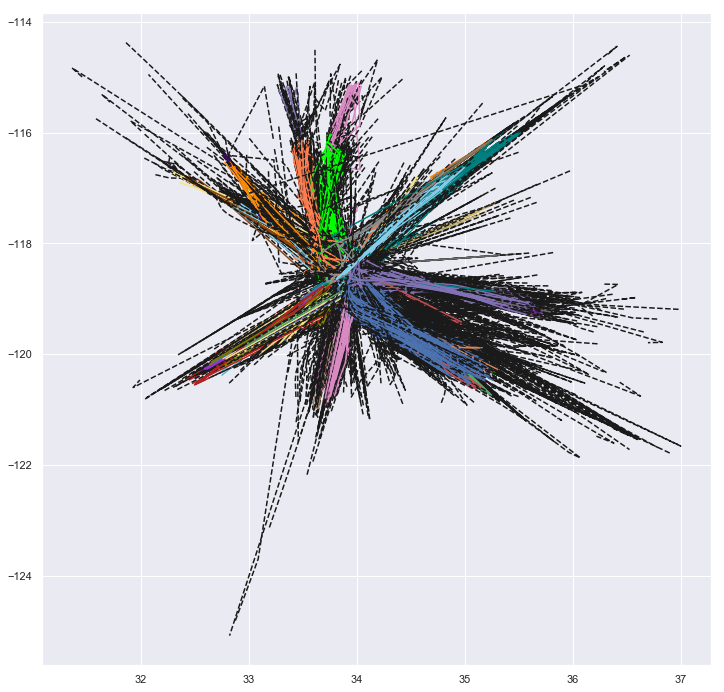

In [27]:
mdl = DBSCAN(eps=3, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 46 clusters found


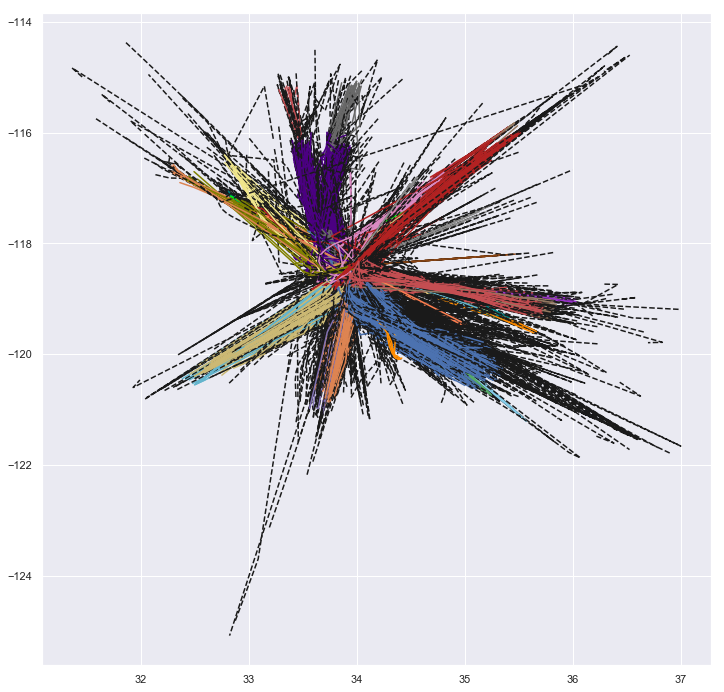

In [29]:
mdl = DBSCAN(eps=3.5, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 35 clusters found


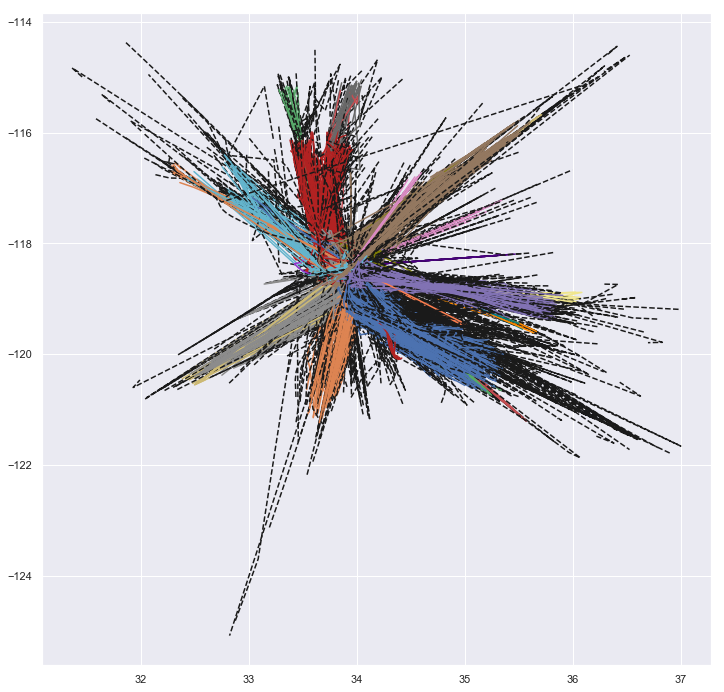

In [25]:
mdl = DBSCAN(eps=4, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 32 clusters found


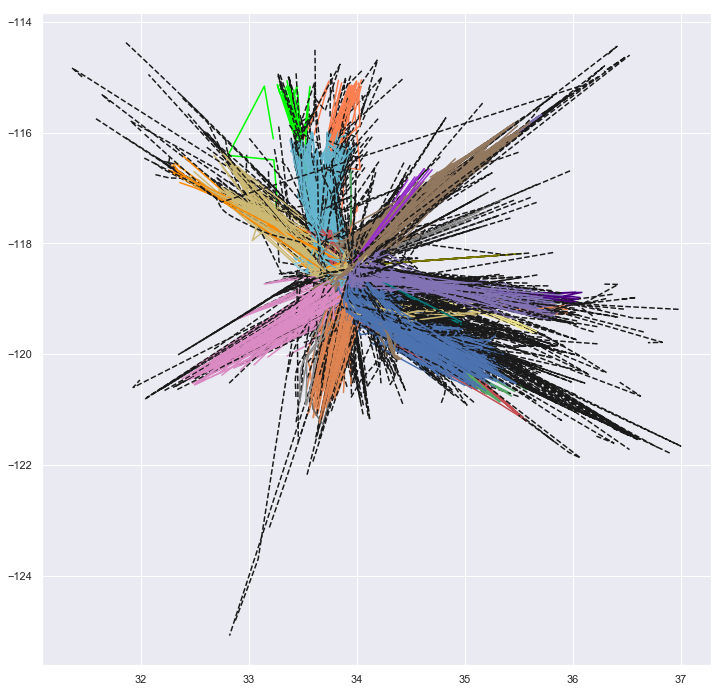

In [28]:
mdl = DBSCAN(eps=4.5, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 27 clusters found


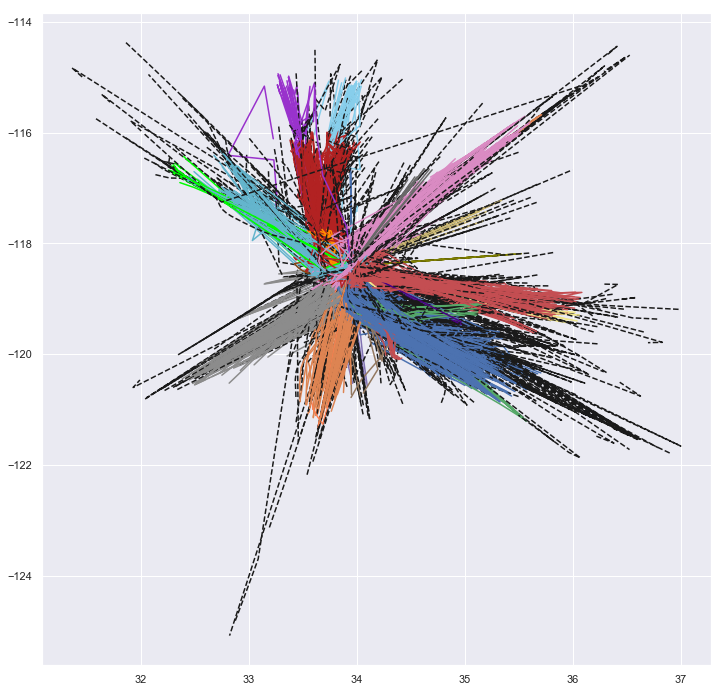

In [23]:
mdl = DBSCAN(eps=5, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 17 clusters found


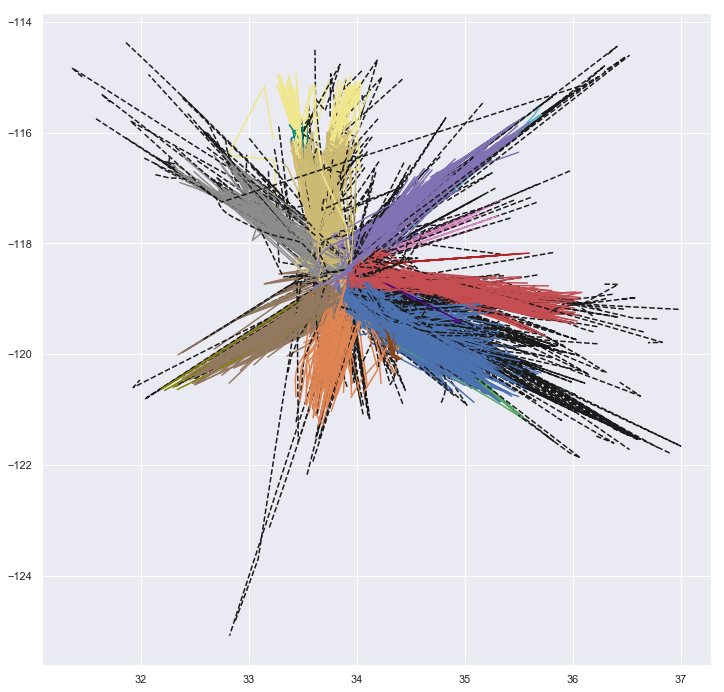

In [30]:
mdl = DBSCAN(eps=6, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 14 clusters found


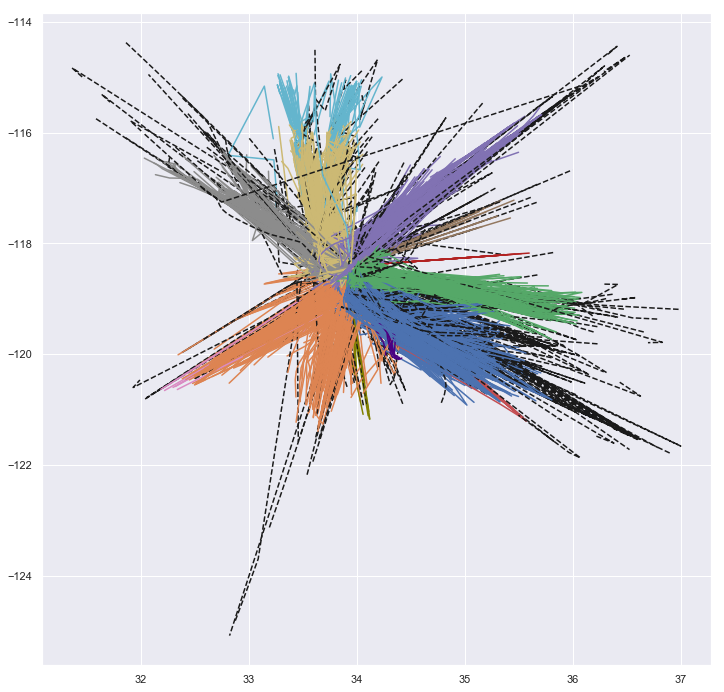

In [26]:
mdl = DBSCAN(eps=7, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 9 clusters found


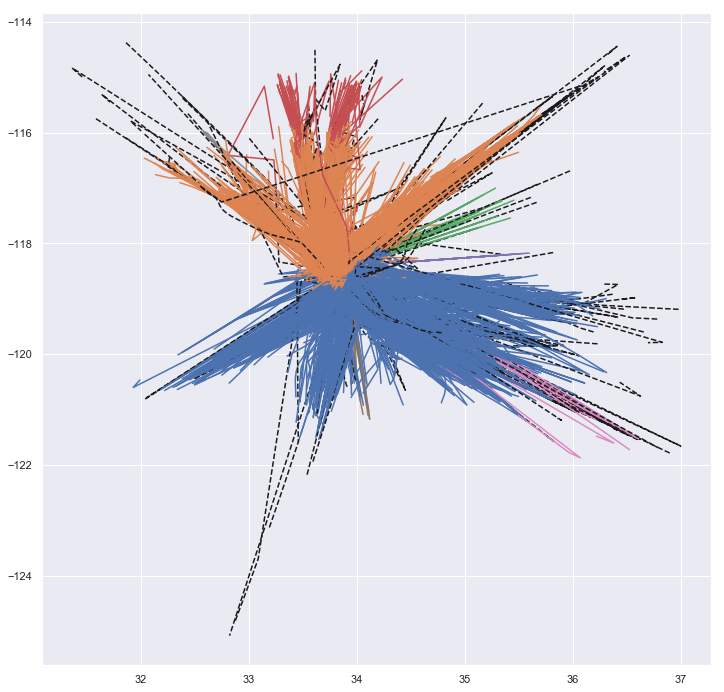

In [21]:
mdl = DBSCAN(eps=10, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 4 clusters found


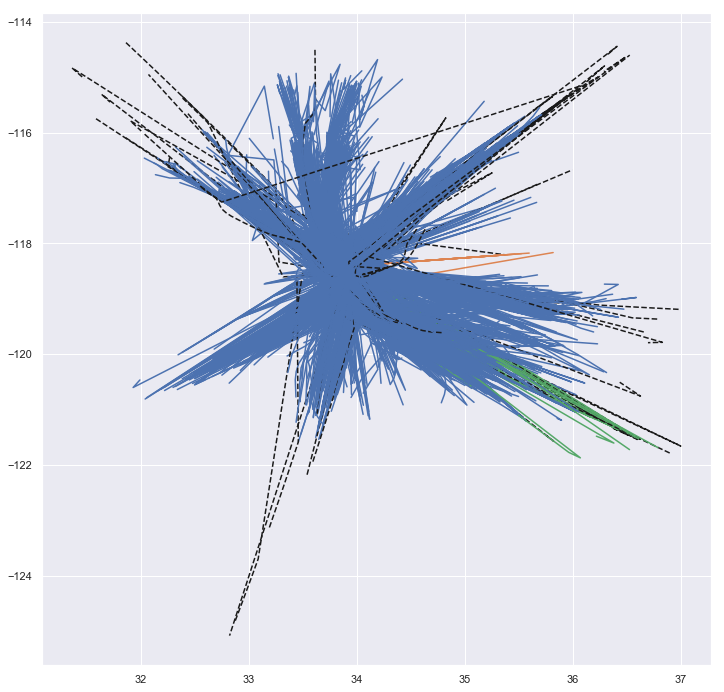

In [24]:
mdl = DBSCAN(eps=15, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 4 clusters found


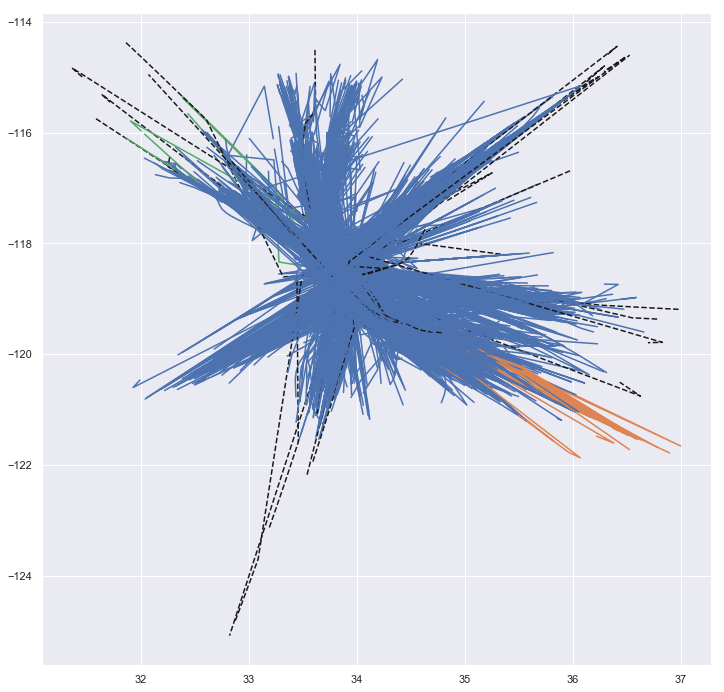

In [17]:
mdl = DBSCAN(eps=20, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)

There were 1 clusters found


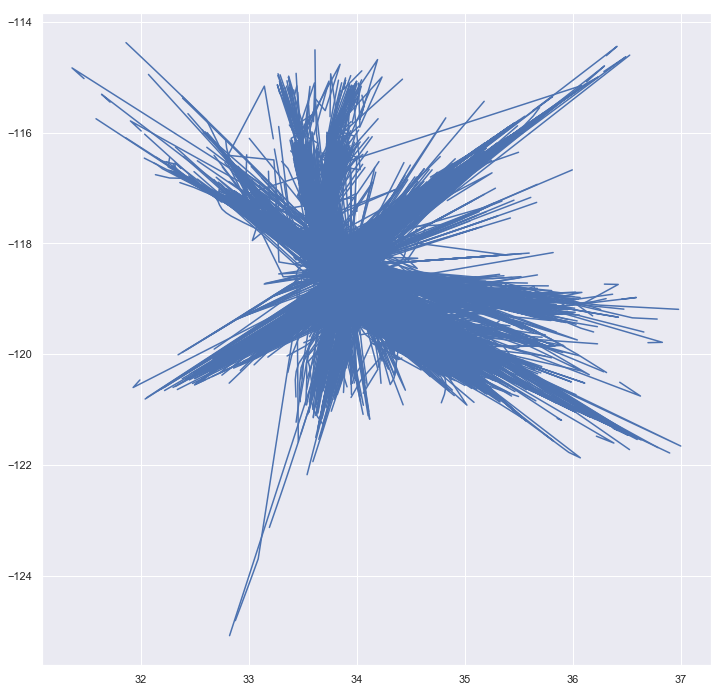

In [19]:
mdl = DBSCAN(eps=200, min_samples=5)
cluster_lst = mdl.fit_predict(D)
num_clusters = len(np.unique(cluster_lst))
print('There were %i clusters found' %num_clusters)

plot_cluster(traj_lst, cluster_lst)